# Motivation

# Python Imports

In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import numpy as np
import missingno as msno
import altair as alt
from vega_datasets import data


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn import preprocessing

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import re
from sklearn.base import BaseEstimator, TransformerMixin
import nltk.stem


# Data Set

In [2]:
df = pd.read_csv('/Users/stewarta/repos/charity-filter-evaluation/evaluation/data/charity_navigator.csv')
df.head()

,Unnamed: 0,category,cause,charityid,mission,tagline
0,0,arts culture humanities,museums,9745,the utah museum of contemporary art advances a...,utah premiere venue for contemporary art
1,1,health,diseases disorders and disciplines,8857,the national mps society exists to find cures ...,support for families research for cure
2,2,health,patient and family support,14464,the ronald mcdonald house of san francisco rmh...,the house that love built
3,3,human services,social services,4177,the mission of the national federation of the ...,live the life you want
4,4,animals,zoos and aquariums,3718,the oldest zoo in texas the fort worth zoo was...,strengthening the bond between humans and the ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 6 columns):
Unnamed: 0    9119 non-null int64
category      9119 non-null object
cause         9119 non-null object
charityid     9119 non-null int64
mission       8654 non-null object
tagline       8699 non-null object
dtypes: int64(2), object(4)
memory usage: 427.5+ KB


# Preprocess and Explore Data 

## Uniformative Columns

In [9]:
print(df.columns)
df.drop(['Unnamed: 0','charityid'], axis=1, inplace=True)
df.head()

Index(['Unnamed: 0', 'category', 'cause', 'charityid', 'mission', 'tagline'], dtype='object')


,category,cause,mission,tagline
0,arts culture humanities,museums,the utah museum of contemporary art advances a...,utah premiere venue for contemporary art
1,health,diseases disorders and disciplines,the national mps society exists to find cures ...,support for families research for cure
2,health,patient and family support,the ronald mcdonald house of san francisco rmh...,the house that love built
3,human services,social services,the mission of the national federation of the ...,live the life you want
4,animals,zoos and aquariums,the oldest zoo in texas the fort worth zoo was...,strengthening the bond between humans and the ...


## Missing Rows

### Visualize Missing Rows

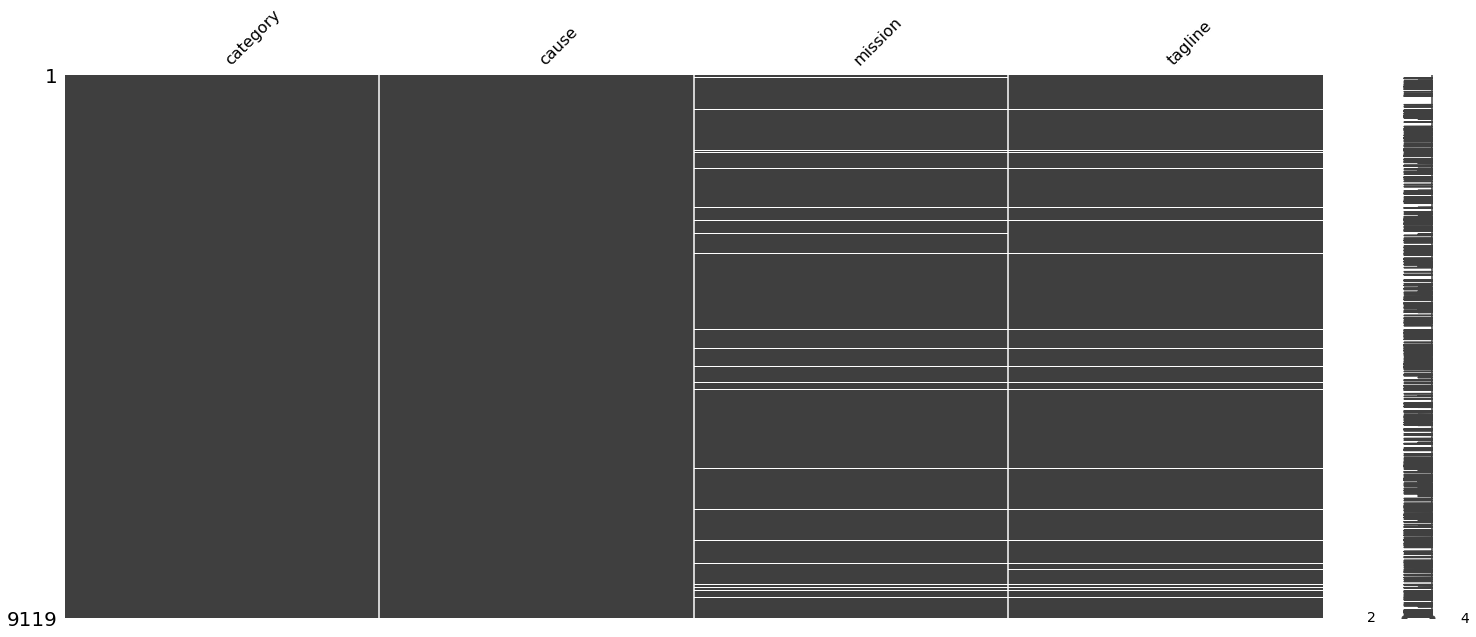

In [10]:
msno.matrix(df)

### Drop Missing Rows

In [3]:
## Drop Empty Rows
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8638 entries, 0 to 9118
Data columns (total 6 columns):
Unnamed: 0    8638 non-null int64
category      8638 non-null object
cause         8638 non-null object
charityid     8638 non-null int64
mission       8638 non-null object
tagline       8638 non-null object
dtypes: int64(2), object(4)
memory usage: 472.4+ KB


## Check Class Balance

We can upsample to handle the class imbalance or use an algorithm (e.g.: Tree-based) that is insensitve to the class imbalance.

In [5]:
pic = pd.DataFrame(df['category'].value_counts())

In [6]:
pic['name'] = pic.index.values.tolist()

In [49]:
pic

,category
human services,2430
arts culture humanities,1228
health,894
community development,807
education,671
international,626
animals,485
religion,465
environment,447
human and civil rights,370


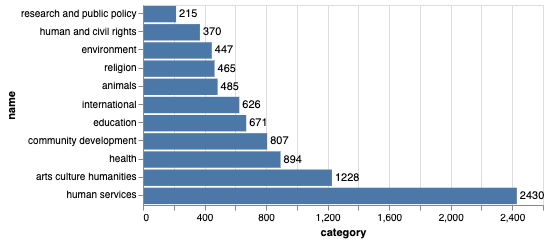

In [7]:
source = pic

bars = alt.Chart(source).mark_bar().encode(
     x='category:Q',
     y=alt.Y(
        "name:O",
        sort=alt.EncodingSortField(
            field="category",  # The field to use for the sort
            #op="sum",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in
        )
    )
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='category:Q'
)

(bars + text).properties(height=200)

# Subset Data for Analysis

Use a subset of the data for analysis

In [14]:
target_lst = ['museums', 'united ways' ,'development and relief services',
              'advocacy and education','children and family services']

In [15]:
df = df.loc[df['cause'].isin(target_lst)]

# Extraction Features

## Encode Target 


In [16]:
target = 'cause'

le = preprocessing.LabelEncoder()
le.fit(df[target])
#print(le.classes_)
df['target'] = le.transform(df[target]) 
df['target'].value_counts()[0:10]

3    397
4    395
2    388
0    370
1    356
Name: target, dtype: int64

## Apply Custom Analyzer

The data set contains many mention to year and organization was founded, which we will not be important for matching news articles. All numbers were remove with regex as a preprocessing step.

In addition, many words appear duplicated due to variations on the ending of the word. Endings were stemmed using  Snowball stemming for NLTK package

stop : 9514
doc freq: 6780
remove number: 6486
stem : 4388

### Aggregate Text Fields

In [8]:
# merge text to create a document
df['corpus'] = df.mission + df.tagline + df.category
# drop other columns, convenience
df.drop(['mission', 'tagline', 'category'], axis=1, inplace=True)

df.head()

,Unnamed: 0,cause,charityid,corpus
0,0,museums,9745,the utah museum of contemporary art advances a...
1,1,diseases disorders and disciplines,8857,the national mps society exists to find cures ...
2,2,patient and family support,14464,the ronald mcdonald house of san francisco rmh...
3,3,social services,4177,the mission of the national federation of the ...
4,4,zoos and aquariums,3718,the oldest zoo in texas the fort worth zoo was...


In [13]:
df.shape

(8638, 4)

In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.corpus)
print(len(vectorizer.get_feature_names()))

12456


In [18]:
df.shape

(1906, 5)

### Stem Words and Filter Integers

In [16]:
# preprocessing step 
def drop_integers(s):
    return re.sub(r'\d+', '', s)

In [17]:
# stemmer
english_stemmer = nltk.stem.SnowballStemmer('english')

def stemmer(doc):
    return [porter_stemmer.stem(w) for w in analyzer(doc)]

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        # will need to rewrite if pickled - due to lambda
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])
   

In [18]:
vectorizer_s = StemmedCountVectorizer(min_df=5,  preprocessor=drop_integers,
                                      analyzer='word', stop_words='english') 

X = vectorizer_s.fit_transform(df.corpus)
print(X.shape)
print(vectorizer_s.get_feature_names()[0:20])

(1906, 1867)
['abandon', 'abil', 'abl', 'abort', 'abroad', 'abus', 'abusehuman', 'academ', 'academi', 'accept', 'access', 'acclaim', 'accomplish', 'accord', 'account', 'accredit', 'accur', 'achiev', 'aclu', 'acquir']


In [19]:
vectorizer = TfidfTransformer()
X_tfidf = vectorizer.fit_transform(X)
print(X_tfidf.shape)
print(X_tfidf)

(1906, 1867)
  (0, 1807)	0.1541249284587658
  (0, 1786)	0.2267533011623153
  (0, 1775)	0.4769691023979484
  (0, 1664)	0.19650988684357845
  (0, 1603)	0.19506506787097247
  (0, 1331)	0.18108536782820472
  (0, 1164)	0.10003609683356515
  (0, 1009)	0.1302599890735798
  (0, 950)	0.12482613414500161
  (0, 917)	0.13521390822121357
  (0, 858)	0.07682922351657642
  (0, 628)	0.2205993357810796
  (0, 598)	0.13124899241125457
  (0, 547)	0.2434036022307188
  (0, 470)	0.21786933432061167
  (0, 408)	0.1778105901141414
  (0, 364)	0.46520864539121537
  (0, 321)	0.06170245235687211
  (0, 112)	0.17739847719972426
  (0, 111)	0.22546613864971732
  (0, 39)	0.119907083113257
  (1, 1854)	0.18319507138581564
  (1, 1776)	0.19800917495020406
  (1, 1774)	0.13408411214334748
  (1, 1758)	0.178097721501643
  :	:
  (1905, 1005)	0.08583886857036259
  (1905, 971)	0.1590118035975813
  (1905, 917)	0.08080120299115248
  (1905, 893)	0.21800322753312967
  (1905, 888)	0.11682219765635363
  (1905, 884)	0.07421949041715067
  

# Create Train and Test Sets

Dont forget to shuffle the data

In [25]:
seed = 2
X_train, X_test, y_train, y_test = train_test_split(df.corpus, df.target,
                                                    test_size=0.20,
                                                    random_state=seed, 
                                                    shuffle=True)

# Define Pipelines

In [26]:
NB_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(alpha=0.01)),
])

LR_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0, solver='lbfgs',
                               multi_class='multinomial')),
])

SVC_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

RF_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=100, 
                                   max_depth=2)),
])

SGD_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3)),
])

In [27]:
## naive bayes
NB_pipeline.fit(X_train, y_train)
predictionNB = NB_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictionNB)))

Test accuracy is 0.9528795811518325


In [28]:
## Logistic Regression
LR_pipeline.fit(X_train, y_train)
preditionLR = LR_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,preditionLR)))

Test accuracy is 0.9581151832460733


In [29]:
## Suport Vector
SVC_pipeline.fit(X_train, y_train)
preditionSVC = SVC_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,preditionSVC)))

Test accuracy is 0.9659685863874345


In [31]:
SGD_pipeline.fit(X_train,y_train)
predictionSGD = SGD_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictionSGD)))

Test accuracy is 0.9685863874345549


In [32]:
# random forest
RF_pipeline.fit(X_train,y_train)
predictionRF = RF_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictionRF)))

Test accuracy is 0.8089005235602095


In [36]:
results = {'Algorithm': ['naive_bayes', 'logistic_regression','support_vector','gradient_descent','random_forest' ],
           'Accuracy': [0.95,0.96,0.96,0.97,0.81] }
res_df = pd.DataFrame(results)
res_df.head()

,Algorithm,Accuracy
0,naive_bayes,0.95
1,logistic_regression,0.96
2,support_vector,0.96
3,gradient_descent,0.97
4,random_forest,0.81


In [52]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
Algorithm    5 non-null object
Accuracy     5 non-null float64
dtypes: float64(1), object(1)
memory usage: 160.0+ bytes


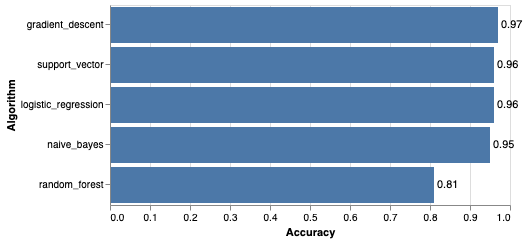

In [54]:
#Data Type	Shorthand Code	Description
#quantitative	Q	a continuous real-valued quantity
#ordinal	O	a discrete ordered quantity
#nominal	N	a discrete unordered category
#temporal	T	a time or date value

source = res_df

bars = alt.Chart(source).mark_bar().encode(
     x='Accuracy:Q',
     y=alt.Y("Algorithm:N",
             sort=alt.EncodingSortField(
                 field="Accuracy",  # The field to use for the sort
                 order="descending"  # The order to sort in
             )
            )
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Accuracy:Q'
)

(bars + text).properties(height=200)

# Configure Grid Search

## Define Grid Parameters

In [21]:
# Set grid search params
param_range = [1, 3]

grid_params_mnb = [{
    'vect__ngram_range': [(1, 1)],
    'clf__fit_prior': (True, False),
}] 


grid_params_svm = [{
    'vect__ngram_range': [(1, 1)],
    'clf__C': param_range,
}]

grid_params_sgd = [{
    'vect__ngram_range': [(1, 1)],
    'clf__penalty': ['l2'],
    'clf__loss' : ('hinge'),
    'clf__alpha': (1e-2, 1e-3),
}]

## Initialize Grid 

In [22]:
# Construct grid objects

gs_mnb = GridSearchCV(
    estimator=pipe_mnb,
    param_grid=grid_params_mnb,
    scoring='accuracy',
    cv=10) 

gs_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=grid_params_svm,
    scoring='accuracy',
    cv=10)

gs_sgd = GridSearchCV(
    estimator=pipe_sgd,
    param_grid=grid_params_sgd,
    scoring='accuracy',
    cv=10, 
    n_jobs=jobs)

# List of pipelines for ease of iteration
#grids = [gs_mnb, gs_svm, gs_sgd]
grids = [gs_sgd]

# Dictionary of pipelines and classifier types for ease of reference
#grid_dict = {0: 'Multinomial Naive Bayes', 1: 'Support Vector Machine', 
#             2: 'Stocastic Gradient Descent'}

grid_dict = {0: 'Stocastic Gradient Descent'}

# Build Model and Evaluate Performance 

In [23]:
# Fit the grid search objects

X_train, X_test, y_train, y_test = train_test_split(df.corpus, df.target, test_size=0.20, random_state=seed)

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params 
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
#dump_file = 'best_gs_pipeline.pkl'
#joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Stocastic Gradient Descent


TypeError: super(type, obj): obj must be an instance or subtype of type